In [1]:
## 10000 events gets me to 5 sigma (5.07) with S+B vs B-only separation
## 50000 events gets me to 5 sigma (5.13) with B-only rejection

In [2]:
## try H->gg case
import numpy as np
from numba_stats import expon_pdf, expon_cdf, norm_pdf, norm_cdf
from scipy.stats import truncexpon, truncnorm
import matplotlib.pyplot as plt
np.random.seed(210187)

mrange = (100,160)
mbins = 50
lb = 40
mu = 125
sg = 1
f = 0.01

# define normalised s+b pdfs with rapid evaluation from numba_stats
def spdf(x,mu=mu,sg=sg):
    sn = np.diff( norm_cdf(mrange,mu,sg) )
    return norm_pdf(x,mu,sg) / sn

def bpdf(x,lb=lb):
    bn = np.diff( expon_cdf(mrange,mrange[0],lb) )
    return expon_pdf(x,mrange[0],lb) / bn
    
# also make definitions using scipy stats that can be used for generation
sig = truncnorm( (mrange[0]-mu)/sg, (mrange[1]-mu)/sg, mu, sg)
bkg = truncexpon( (mrange[1]-mrange[0])/lb, mrange[0], lb)


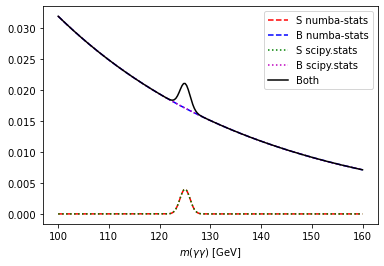

In [3]:
# better plot these to check they do what we want

x = np.linspace(mrange[0],mrange[1],200)


s = f * spdf(x)
b = (1-f) * bpdf(x)

fig, ax = plt.subplots()
ax.plot(x, f * spdf(x), 'r--', label='S numba-stats')
ax.plot(x, (1-f) * bpdf(x), 'b--', label='B numba-stats')
ax.plot(x, f*sig.pdf(x), 'g:', label='S scipy.stats')
ax.plot(x, (1-f)*bkg.pdf(x), 'm:', label='B scipy.stats')
ax.plot(x, s+b, 'k-', label='Both')
ax.legend()
_ = ax.set_xlabel('$m(\gamma\gamma)$ [GeV]')



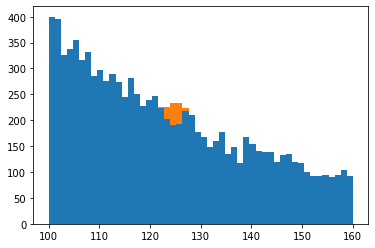

In [4]:
## generate s+b large samples (with poisson variation)
n = 10000
# use scipy stats for this
bkg_toy = bkg.rvs(size=np.random.poisson((1-f)*n))
sig_toy = sig.rvs(size=np.random.poisson(f*n))
toy = np.append(bkg_toy,sig_toy)

fig, ax = plt.subplots()
_ = ax.hist([bkg_toy,sig_toy], stacked=True, range=mrange, bins=mbins)
#w, xe = np.histogram( toy, range=mrange, bins=mbins)
#cx = 0.5*(xe[1:]+xe[:-1])
#ax.errorbar(cx,w,yerr=w**0.5,fmt='ko', ms=2, capsize=2)


In [5]:
## fit the large sample unbinned to see if the LLR gets us 5 sigma
from iminuit import Minuit
from iminuit.cost import ExtendedUnbinnedNLL

# pdf for minuit (using numba-stats here gives supreme performance)
def pdf(x,ns,mu,sg,nb,lb):
    sig = spdf(x,mu,sg)
    bkg = bpdf(x,lb)
    return (ns+nb, ns*sig+nb*bkg)

m = Minuit( ExtendedUnbinnedNLL( toy, pdf ),
            ns = (1-f)*n,
            nb = f*n,
            mu = 125,
            sg = 1, 
            lb = 40
          )

m.limits['ns'] = (1,n)
m.limits['nb'] = (1,n)
m.limits['mu'] = mrange
m.limits['sg'] = (0,2)
m.limits['lb'] = (5,100)

In [6]:
# fit signal + background only
m.fixed['ns'] = False
m.fixed['mu'] = False
m.fixed['sg'] = False
m.migrad()
m.hesse()
print("######### SIGNAL + BACKGROUND FIT ########")
print(m)
sb_vals = np.array(m.values)
sb_errs = np.array(m.errors)
sb_fval = float(m.fval)


# fit background only
m.values['ns'] = 0
m.fixed['ns'] = True
m.fixed['mu'] = True
m.fixed['sg'] = True
m.migrad()
m.hesse()
print("######### BACKGROUND ONLY FIT ########")
print(m)
bo_vals = np.array(m.values)
bo_errs = np.array(m.errors)
bo_fval = float(m.fval)


######### SIGNAL + BACKGROUND FIT ########
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = -8.492e+04                 │              Nfcn = 352              │
│ EDM = 4.33e-05 (Goal: 0.0002)    │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │       SOME Parameters at limit       │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───

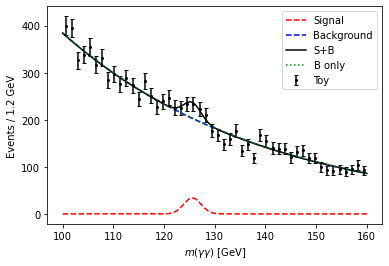

In [7]:
fig, ax = plt.subplots()
w, xe = np.histogram( toy, range=mrange, bins=mbins)
cx = 0.5*(xe[1:]+xe[:-1])
ax.errorbar(cx,w,yerr=w**0.5,fmt='ko', ms=2, capsize=2, label='Toy')

x = np.linspace(*mrange,400)
norm = (mrange[1]-mrange[0])/mbins
sb_sig = norm*sb_vals[m.var2pos['ns']]*spdf(x, sb_vals[m.var2pos['mu']], sb_vals[m.var2pos['sg']])
sb_bkg = norm*sb_vals[m.var2pos['nb']]*bpdf(x, sb_vals[m.var2pos['lb']])
bo_bkg = norm*bo_vals[m.var2pos['nb']]*bpdf(x, bo_vals[m.var2pos['lb']])

ax.plot(x, sb_sig, 'r--', label='Signal')
ax.plot(x, sb_bkg, 'b--', label='Background')
ax.plot(x, sb_sig+sb_bkg, 'k-', label='S+B')
ax.plot(x, bo_bkg, 'g:', label='B only')
ax.legend()
_ = ax.set_xlabel('$m(\gamma\gamma)$ [GeV]')
_ = ax.set_ylabel('Events / {:.1f} GeV'.format((mrange[1]-mrange[0])/mbins))

In [8]:
#print(sb_fval)
#print(bo_fval)
dn2ll = 2*(bo_fval-sb_fval)
print('DNLL significance:', dn2ll**0.5)


bo_bkg = norm*bo_vals[m.var2pos['nb']]*bpdf(cx, bo_vals[m.var2pos['lb']])
chi2 = np.sum( (w-bo_bkg)**2/w )
chi2_pdof = chi2 / (mbins-1)
#print(chi2)
#print(chi2_pdof)

from scipy.stats import chi2 as chi2dist
pval = 1 - chi2dist.cdf(chi2,(mbins-1))
#print(pval)
sig = chi2dist.ppf(1-pval,1)**0.5
print('Chi2 significance:', sig)


DNLL significance: 5.069165627605778
Chi2 significance: 1.846640168530116
